- Path

In [2]:
import os
DIR = "./BuildingMachineLearningSystemsWithPython/ch03/data/toy"
posts = [open(os.path.join(DIR, f)).read() for f in os.listdir(DIR)]

In [3]:
from sklearn.feature_extraction.text import CountVectorizer

- Distance Calculator

In [4]:
def dist_raw(v1, v2):
    delta = v1 - v2
    return sp.linalg.norm(delta.toarray())

In [7]:
def dist_norm(v1, v2):
    v1_normalized = v1 / sp.linalg.norm(v1.toarray())
    v2_normalized = v2 / sp.linalg.norm(v2.toarray())
    delta = v1_normalized - v2_normalized
    return sp.linalg.norm(delta.toarray())

- nltk Stemmer

In [17]:
import nltk.stem
english_stemmer = nltk.stem.SnowballStemmer('english')

- Vectorizer Setting

In [8]:
vectorizer = CountVectorizer(min_df=1, stop_words='english')
X_train = vectorizer.fit_transform(posts)
new_post = "imaging databases"
new_post_vec = vectorizer.transform([new_post])

In [9]:
import sys
best_doc = None
best_dist = 100000
best_i = None
for i, post in enumerate(posts):
    if post == new_post:
        continue
    post_vec = X_train.getrow(i)
    d = dist_norm(post_vec, new_post_vec)
    print("=== Post %i with dist=%.2f: %s" % (i, d, post))
    if d < best_dist:
        best_dist = d
        best_i = i

print("Best post is %i with dist=%.2f" % (best_i, best_dist))

=== Post 0 with dist=1.41: This is a toy post about machine learning. Actually, it contains not much interesting stuff.
=== Post 1 with dist=0.86: Imaging databases provide storage capabilities.
=== Post 2 with dist=0.86: Most imaging databases save images permanently.

=== Post 3 with dist=0.77: Imaging databases store data.
=== Post 4 with dist=0.77: Imaging databases store data. Imaging databases store data. Imaging databases store data.
Best post is 3 with dist=0.77


## Stop words on steroids

- The feature values simply count occurrences of terms in a post. We silently assumed that higher values for a term also mean that the term is of greater importance to the given post. But what about, for instance, the word "subject", which naturally occurs in each and every single post? Alright, we can tell CountVectorizer to remove it as well by means of its max_df parameter. 

- **term frequency – inverse document frequency (TF-IDF) **

In [11]:
import scipy as sp

def tfidf(term, doc, corpus):
    tf = doc.count(term) / len(doc)
    num_docs_with_term = len([d for d in corpus if term in d])
    idf = sp.log(len(corpus) / num_docs_with_term)
    return tf * idf

In [12]:
a, abb, abc = ["a"], ["a", "b", "b"], ["a", "b", "c"]
D = [a, abb, abc]
print(tfidf("a", a, D))

0.0


In [13]:
print(tfidf("a", abb,D))

0.0


In [14]:
print(tfidf("a", abc, D))
print(tfidf("b", abb, D))
print(tfidf("b", abc, D))


0.0
0.270310072072
0.135155036036


In [15]:
print(tfidf("c", abc, D))

0.366204096223


- We see that a carries no meaning for any document since it is contained everywhere. The b term is more important for the document abb than for abc as it occurs there twice. 

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer

class StemmedTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(TfidfVectorizer,
                        self).build_analyzer()
        return lambda doc: (
            english_stemmer.stem(w) for w in analyzer(doc))

In [35]:
vectorizer = StemmedTfidfVectorizer(min_df=1,
                                   stop_words='english',
                                   decode_error='ignore')

## Our achievements and goals

> steps
- firstly, tokenizing the text
- This is followed by throwing away words that occur way too often to be of any help in detecting relevant posts
- Throwing away words that occur way so seldoom so that there is only little changce that occur in future posts.
- Counting the remaining words
- Finally, calculating TF-IDF values from the counts, considering the whole text corpus.

> Drawbacks of *bag of words*

- It does not cover word relations
- It does not capture negations correctly
- It totally fails with misspelled words

## Clustering

-  Most clustering algorithms fall into one of the two methods: flat and hierarchical clustering. 

- **Flat clustering divides the posts into a set of clusters without relating the clusters to each other. The goal is simply to come up with a partitioning such that all posts in one cluster are most similar to each other while being dissimilar from the posts in all other clusters.** Many flat clustering algorithms require the number of clusters to be specified up front. 

- In hierarchical clustering, the number of clusters does not have to be specified. Instead, hierarchical clustering creates a hierarchy of clusters. While similar posts are grouped into one cluster, similar clusters are again grouped into one uber-cluster. This is done recursively, until only one cluster is left that contains everything. In this hierarchy, one can then choose the desired number of clusters after the fact. However, this comes at the cost of lower efficiency. 

### K- means

### 20 news groups

In [36]:
import sklearn.datasets

In [37]:
all_data = sklearn.datasets.fetch_20newsgroups(subset='all')

In [38]:
len(all_data.filenames)

18846

In [39]:
print(all_data.target_names)

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


In [65]:
groups = ['comp.graphics', 'comp.os.ms-windows.misc', \
          'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',  \
          'comp.windows.x', 'sci.space']
datasets = sklearn.datasets.fetch_20newsgroups(categories=groups)
train_data = sklearn.datasets.fetch_20newsgroups(
    subset='train', categories=groups)
test_data = sklearn.datasets.fetch_20newsgroups(subset='test', categories=groups) 
                                                 

In [62]:
type(datasets.data)

list

In [63]:
type(train_data.data)

list

In [66]:
print(len(datasets.data))
print(len(train_data.data))
print(len(test_data.data))

3529
3529
2349


### Posts Clustering

In [33]:
len(train_data.data)

3529

In [40]:
vectorizer = StemmedTfidfVectorizer(min_df=10, max_df=0.5,
                                   stop_words='english', decode_error='ignore')
vectorized = vectorizer.fit_transform(train_data.data)
vectorized.shape

(3529, 4712)

In [45]:
type(vectorized)

scipy.sparse.csr.csr_matrix

In [46]:
from sklearn.cluster import KMeans

In [47]:
num_clusters = 50

In [49]:
km = KMeans(n_clusters=num_clusters, init='random', n_init=1,
           verbose=1, random_state=3)
km.fit(vectorized)

Initialization complete
Iteration  0, inertia 5899.560
Iteration  1, inertia 3218.298
Iteration  2, inertia 3184.333
Iteration  3, inertia 3164.867
Iteration  4, inertia 3152.004
Iteration  5, inertia 3143.111
Iteration  6, inertia 3136.256
Iteration  7, inertia 3129.325
Iteration  8, inertia 3124.567
Iteration  9, inertia 3121.900
Iteration 10, inertia 3120.210
Iteration 11, inertia 3118.627
Iteration 12, inertia 3117.363
Iteration 13, inertia 3116.811
Iteration 14, inertia 3116.588
Iteration 15, inertia 3116.417
Iteration 16, inertia 3115.760
Iteration 17, inertia 3115.374
Iteration 18, inertia 3115.155
Iteration 19, inertia 3114.949
Iteration 20, inertia 3114.515
Iteration 21, inertia 3113.937
Iteration 22, inertia 3113.720
Iteration 23, inertia 3113.548
Iteration 24, inertia 3113.475
Iteration 25, inertia 3113.447
Converged at iteration 25: center shift 0.000000e+00 within tolerance 2.069005e-08


KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300,
    n_clusters=50, n_init=1, n_jobs=1, precompute_distances='auto',
    random_state=3, tol=0.0001, verbose=1)

In [51]:
print(km.labels_)

[38 17 47 ..., 41 14 16]


In [52]:
print(km.labels_.shape)

(3529,)


In [53]:
new_post = """
Disk drive problems.
Hi, I have a problem with my hard disk. 
After 1 year it is working only sporadically now. 
I tried to format it, but now it doesn't boot any more. 
Any ideas? Thanks"""

In [54]:
new_post_vec = vectorizer.transform([new_post])
new_post_label = km.predict(new_post_vec)[0]

In [56]:
similar_indices = (km.labels_==new_post_label).nonzero()[0]

In [68]:
similar = []
for i in similar_indices:
    dist = sp.linalg.norm((new_post_vec - vectorized[i]).toarray())
    similar.append((dist, train_data.data[i]))
    
similar = sorted(similar)
print(len(similar))

166


In [69]:
print(similar[0])

(1.0378441731334072, "From: Thomas Dachsel <GERTHD@mvs.sas.com>\nSubject: BOOT PROBLEM with IDE controller\nNntp-Posting-Host: sdcmvs.mvs.sas.com\nOrganization: SAS Institute Inc.\nLines: 25\n\nHi,\nI've got a Multi I/O card (IDE controller + serial/parallel\ninterface) and two floppy drives (5 1/4, 3 1/2) and a\nQuantum ProDrive 80AT connected to it.\nI was able to format the hard disk, but I could not boot from\nit. I can boot from drive A: (which disk drive does not matter)\nbut if I remove the disk from drive A and press the reset switch,\nthe LED of drive A: continues to glow, and the hard disk is\nnot accessed at all.\nI guess this must be a problem of either the Multi I/o card\nor floppy disk drive settings (jumper configuration?)\nDoes someone have any hint what could be the reason for it.\nPlease reply by email to GERTHD@MVS.SAS.COM\nThanks,\nThomas\n+-------------------------------------------------------------------+\n| Thomas Dachsel                                         

### Another look at noise

In [70]:
post_group = zip(train_data.data, train_data.target)

In [71]:
all_ = [(len(post[0]), post[0], train_data.target_names[post[1]]) \
        for post in post_group]
graphics = sorted([post for post in all_ if post[2] == 'comp.graphics'])
print(graphics[5])


(245, 'From: SITUNAYA@IBM3090.BHAM.AC.UK\nSubject: test....(sorry)\nOrganization: The University of Birmingham, United Kingdom\nLines: 1\nNNTP-Posting-Host: ibm3090.bham.ac.uk\n\n==============================================================================\n', 'comp.graphics')


In [79]:
noise_post = graphics[5][1]
analyzer = vectorizer.build_analyzer()
print(list(analyzer(noise_post)))

['situnaya', 'ibm3090', 'bham', 'ac', 'uk', 'subject', 'test', 'sorri', 'organ', 'univers', 'birmingham', 'unit', 'kingdom', 'line', 'nntp', 'post', 'host', 'ibm3090', 'bham', 'ac', 'uk']


In [83]:
useful = set(analyzer(noise_post)).intersection(
    vectorizer.get_feature_names())
print(sorted(useful))

['ac', 'birmingham', 'host', 'kingdom', 'nntp', 'sorri', 'test', 'uk', 'unit', 'univers']


In [84]:
for term in sorted(useful):
    print('IDF(%s)=%.2f' % (term,
            vectorizer._tfidf.idf_[vectorizer.vocabulary_[term]]))

IDF(ac)=3.51
IDF(birmingham)=6.77
IDF(host)=1.74
IDF(kingdom)=6.68
IDF(nntp)=1.77
IDF(sorri)=4.14
IDF(test)=3.83
IDF(uk)=3.70
IDF(unit)=4.42
IDF(univers)=1.91


- So, the terms with the highest discriminative power, birmingham and kingdom, clearly are not that computer graphics related, the same is the case with the terms with lower IDF scores. Understandably, posts from different newsgroups will be clustered together. 

### Tweaking the parameters

# P. 99 

# Topic modeling

### Latent Dirichlet allocation

- LDA and LDA—unfortunately, there are two methods in machine learning with the initials LDA: latent Dirichlet allocation, which is a topic modeling method and linear discriminant analysis, which is a classification method. They are completely unrelated, except for the fact that the initials LDA can refer to either. In certain situations, this can be confusing. The scikit-learn tool has a submodule, sklearn. lda, which implements linear discriminant analysis. At the moment, scikit-learn does not implement latent Dirichlet allocation.

In [93]:
from gensim import corpora, models
corpus = corpora.BleiCorpus('./data/ap/ap.dat', './data/ap/vocab.txt')

In [94]:
model = models.ldamodel.LdaModel(
    corpus,
    num_topics=100,
    id2word=corpus.id2word
)

In [95]:
doc = corpus.docbyoffset(0)
topics = model[doc]
print(topics)

[(13, 0.019243580822156551), (29, 0.1092109952956449), (56, 0.022924398128857566), (61, 0.013989144085155617), (67, 0.016279050498817216), (71, 0.22262487439625606), (79, 0.040111477699890333), (90, 0.477758790164864), (93, 0.031190128494195019), (96, 0.018072997021979058)]


- The format of the result is a list of pairs: (topic_index, topic_weight). We can see that only a few topics are used for each document (in the preceding example, there is no weight for topics 0, 1, and 2; the weight for those topics is 0). The topic model is a sparse model, as although there are many possible topics; for each document, only a few of them are used. 

- This is not strictly true as all the topics have a nonzero probability in the LDA model, but some of them have such a small probability **that we can round it to zero as a good approximation**

In [96]:
num_topics_used = [len(model[doc]) for doc in corpus]

(0, 100)

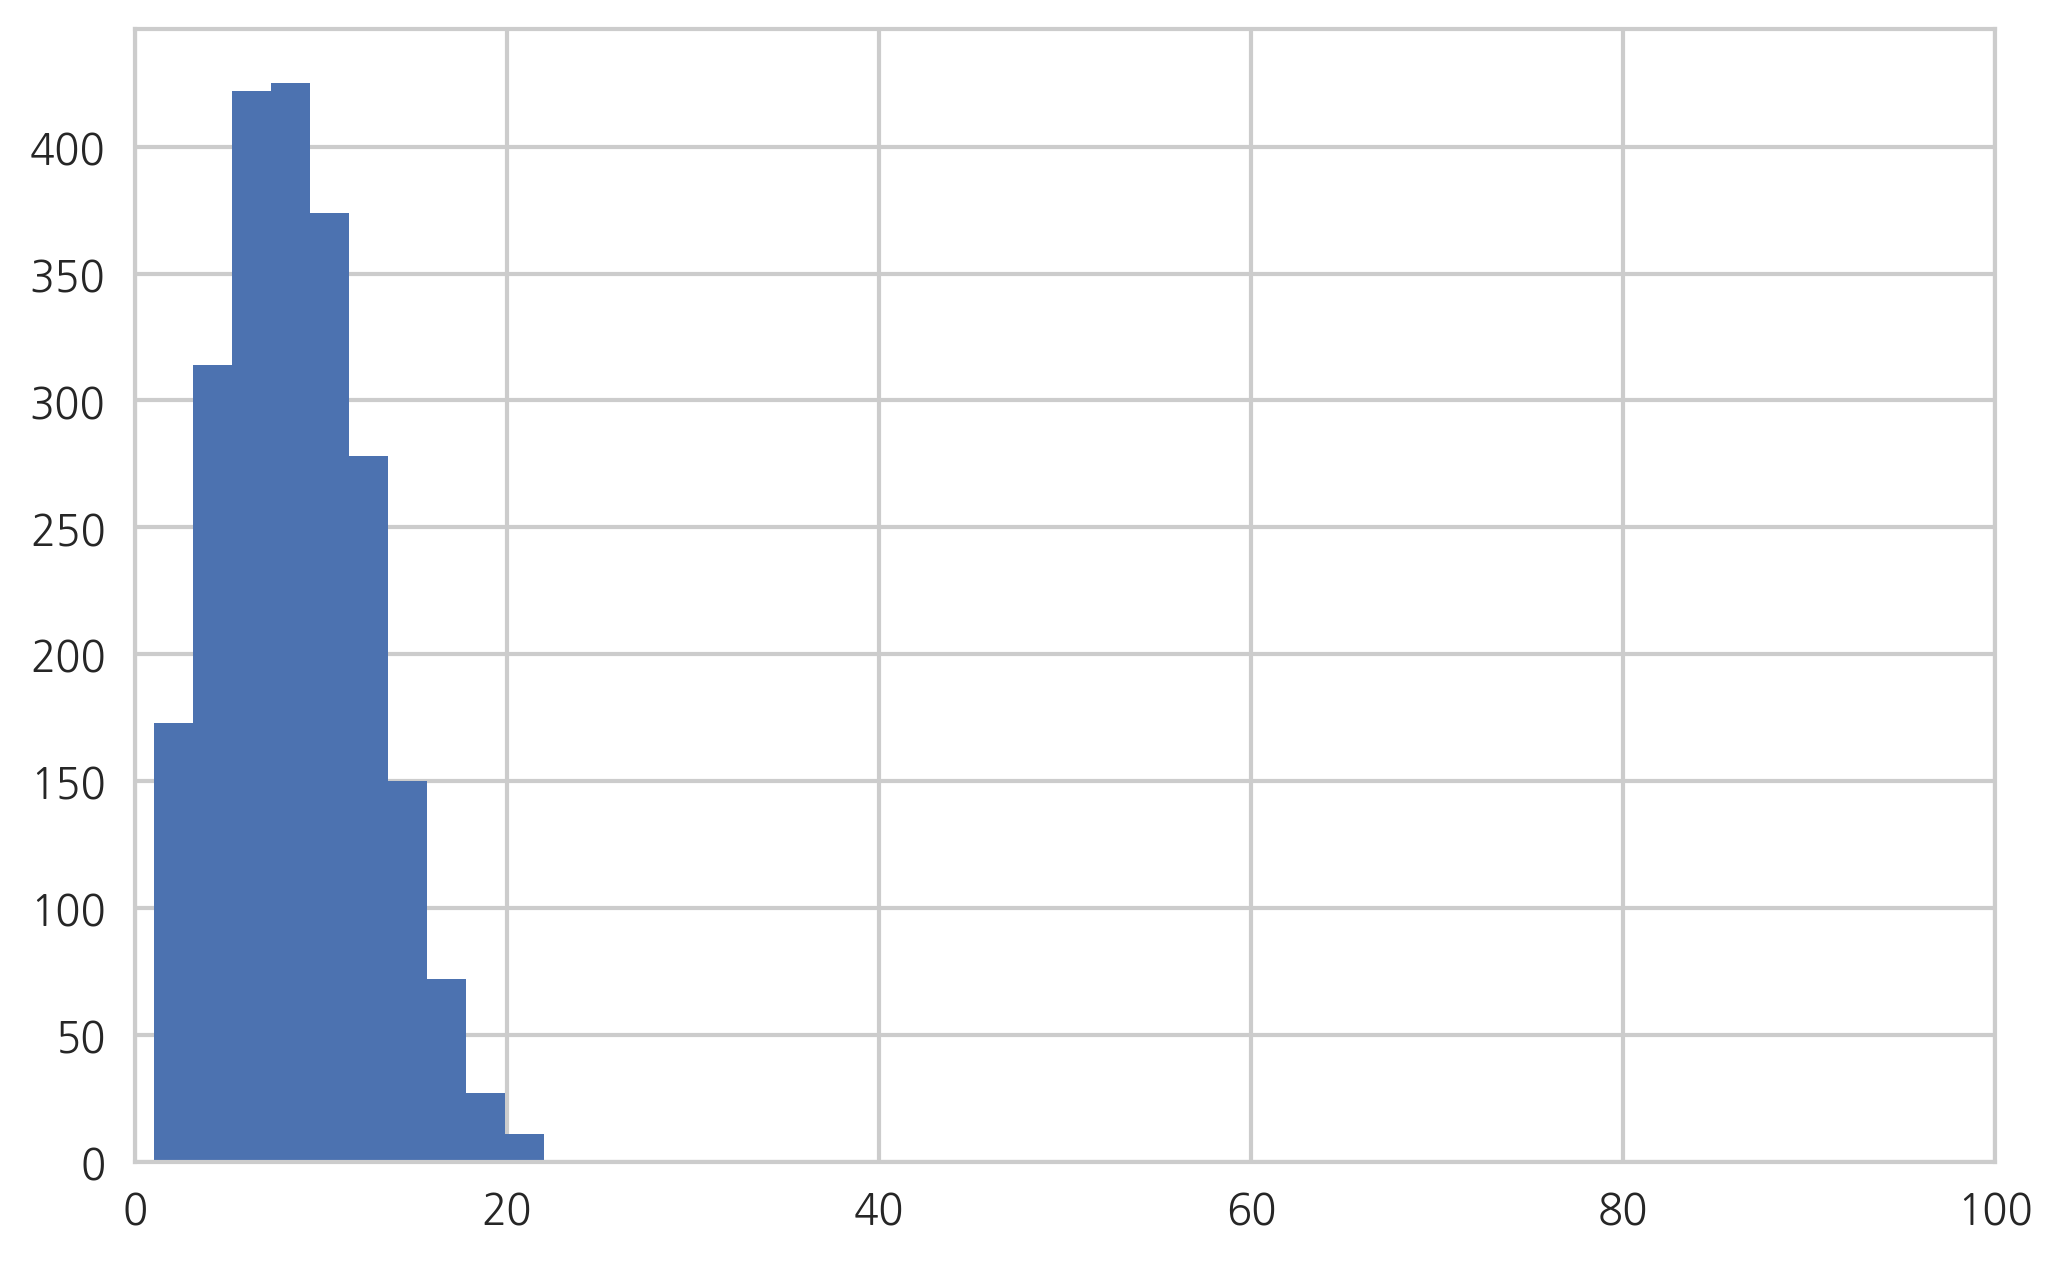

In [98]:
plt.hist(num_topics_used)
plt.xlim(0, 100)

- Sparsity means that while you may have large matrices and vectors, in principle, most of the values are zero (or so small that we can round them to zero as a good approximation). Therefore, only a few things are relevant at any given time. 

- To a large extent, this is due to the value of the parameters that were used, namely, the **alpha parameter**. The exact meaning of alpha is a bit abstract, but bigger values for alpha will result in more topics per document. 

In [99]:
model = models.ldamodel.LdaModel(
    corpus,
    num_topics=100,
    id2word=corpus.id2word,
    alpha=1
)

In [100]:
num_topics_used = [len(model[doc]) for doc in corpus]

In [ ]:
plt.hist(num_topics_used)
plt.xlim(0, 100)

### Comparing Documents by topics

- However, topics are often just an intermediate tool to another end. Now that we have an estimate for each document of how much of that document comes from each topic, we can compare the documents in topic space. This simply means that instead of comparing word to word, we say that two documents are similar if they talk about the same topics. 

- At this point, we can redo the exercise we performed in the last chapter and look for the most similar post to an input query, by using the topics to define similarity. Whereas, **earlier we compared two documents by comparing their word vectors directly, we can now compare two documents by comparing their topic vectors.**

# P. 108